### Ноутбук содержащий бейзлайн решение для соревнования в рамках весеннего МЛ интенсива Академии Яндекса 2023

#### Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.12.0


#### Скачаем данные

Json файл с ключом к kaggle API можно сгенерировать и скачать по ссылке [тык](https://www.kaggle.com/alexnikko/account): **API -> create new API token**

После этого загрузите файл *kaggle.json* в колаб и выполните ячейку ниже - данные сами скачаются и распакуются

In [4]:
!mkdir /root/.kaggle/
with open("/root/.kaggle/kaggle.json", "w") as file:
    file.write('{"username":"burindima","key":"3dc92a9952274c1e89f2f8a09d84f9c0"}')
!kaggle competitions download -c ml-intensive-of-yandex-academy-2023
!unzip ml-intensive-of-yandex-academy-2023.zip 

mkdir: cannot create directory ‘/root/.kaggle/’: File exists
ml-intensive-of-yandex-academy-2023.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ml-intensive-of-yandex-academy-2023.zip
replace data_test? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Считаем данные и посмотрим какую-нибудь информацию по ним

In [3]:
train_data = pd.read_pickle('data_train')
test_data = pd.read_pickle('data_test')

print(f'Train data keys: {train_data.keys()}')
print(f'Test data keys: {test_data.keys()}\n')
print(f'Shape of train images: {train_data["images"].shape}')
print(f'Shape of test images: {test_data["images"].shape}\n')
print(f'Unique labels: {set(train_data["labels"])}\n')
print(f'Classes distribution: {pd.Series(train_data["labels"]).value_counts(normalize=True)}')

Train data keys: dict_keys(['section', 'labels', 'images'])
Test data keys: dict_keys(['section', 'images'])

Shape of train images: (50000, 32, 32, 3)
Shape of test images: (25000, 32, 32, 3)

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Classes distribution: 1    0.19300
2    0.15190
3    0.11250
4    0.09882
5    0.09208
7    0.07752
6    0.07718
0    0.06682
8    0.06664
9    0.06354
dtype: float64


Видим, что в трейне - **50к** картинок, в тесте - **25к**. 

Классов всего **10** - от 0 до 9 (цифры)

Есть дисбаланс классов: например, домов с номерами 1 **в 3 раза больше**, чем домов с номерами 9

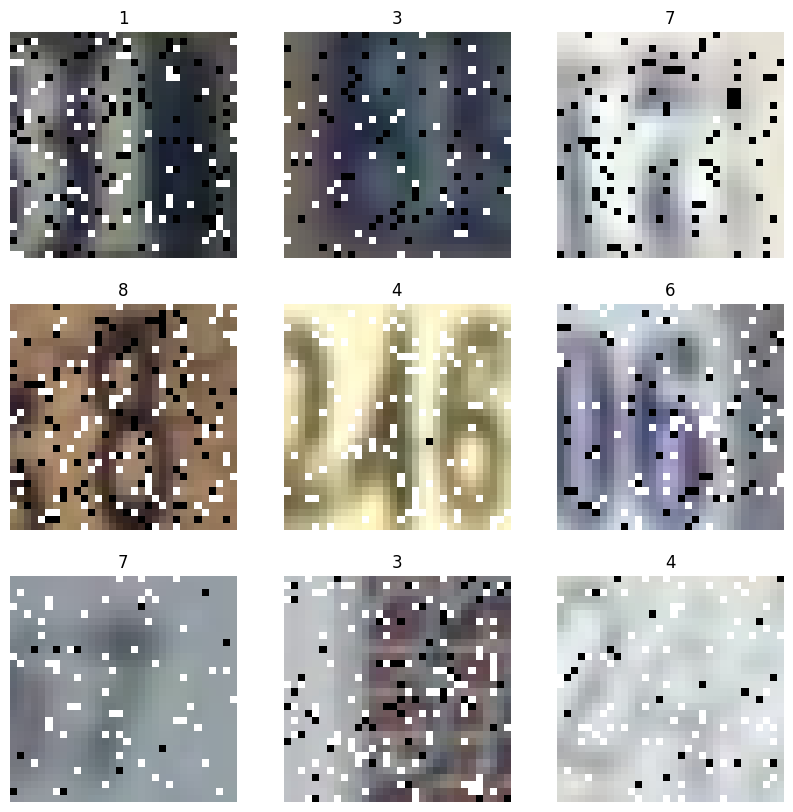

In [5]:
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(len(train_data['images']))
    image = train_data['images'][idx]
    label = train_data['labels'][idx]

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(label)
    plt.axis("off")

#### Создадим простую модель

В качестве нейронной сети возьмем просто перцептрон, то есть двуслойную нейросеть (с двумя линейными слоями)

Во-первых, нам необходимо отмасштабировать картинки из целочисленного диапазона от 0 до 255 (значения пикселей) в вещественный диапазон от 0 до 1. За это будет отвечать слой **Rescaling**.

Во-вторых, нужно "распрямить" картинку. На вход нейронной сети подается трехканальное изображение (RGB) с высотой и шириной равными 32. Таким образом необходимо из размерности 32x32x3 сделать вектор размерности 32*32*3. За это отвечает слой **Flatten**.

Дальше схема простая: x -> Linear -> Relu -> Linear

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1.0 / 255),
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

#### Зададим оптимизатор, функцию потерь и метрики

В качестве оптимизатора возьмем **RMSprop** с параметрами по умолчанию

В качестве функции потерь нам необходимо использовать **Crossentropy** (стандартный лосс для задач классификации)

В качетсве метрик, который будем считать будем использовать accuracy - целевая метрика нашего соревнования

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

#### Обучение модели

Параметры:
- x - тренировочные картинки (numpy array)
- y - тренировочные лейблы (numpy array)
- batch_size - размер батча (пакета)
- epochs - количество эпох обучения 
- validation_split - сколько процентов тренировочных данных использовать в качестве валидации (в данном случае 0.2 - это 20%)
- shuffle - перешивать данные перед началом каждой эпохи или нет

In [ ]:
model.fit(
    x=train_data['images'],
    y=train_data['labels'],
    batch_size=32,
    epochs=1,
    validation_split=0.2,
    shuffle=True
)

1250/1250 [==============================] - 11s 4ms/step - loss: 2.2784 - sparse_categorical_accuracy: 0.1884 - val_loss: 2.2343 - val_sparse_categorical_accuracy: 0.1895


#### Предсказание

Сделаем предсказание модели на тестовом датасете и создадим сабмит

In [ ]:
preds = model.predict(test_data['images'])
pred_labels = preds.argmax(1)
pd.DataFrame({
    'Id': range(pred_labels.size),
    'Category': pred_labels
}).to_csv('sub.csv', index=False)

782/782 [==============================] - 3s 3ms/step


#### Дальнейшие шаги

В какую сторону нужно думать, чтобы улучшить качество:

- **Модель.** Сейчас мы используем простую двуслойную нейронную сеть с линейными слоями. Однако для классификации изображений принято использовать сверточные нейронные сети. Их реализацией и стоит заняться в первую очередь.
- **Данные.** Если посмотреть на данные (картинки), то можно понять, что они не идеальны. Нужно придумать способы, как улучшить их качество. + можно использовать аугментации.
- **Схема тренировки.** В данном ноутбуке практически все параметры заданы по умолчанию, однако можно с ними поэксперементировать. Различные оптимизаторы, learning rate, schedulers - на всё это стоит обратить внимание.

# Избавление от черных точек

In [ ]:
def black_white_point(image):
    # получаем координаты черных пикселей
  black_pixels = np.where(np.all(image == [0, 0, 0], axis=-1))
  print(black_pixels)

  # заменяем черные пиксели на среднее значение пикселей в окрестности 3x3
  for i, j in zip(black_pixels[0], black_pixels[1]):
      # получаем окрестность 3x3 пикселя
      neighborhood = image[max(0, i-1):min(i+2, image.shape[0]), max(0, j-1):min(j+2, image.shape[1])]
      # отсеиваем соль и перец чтобы не мешались
      neighborhood1 = neighborhood.reshape((-1, 3))
      neighborhood1 = neighborhood1[np.nonzero(np.sum(neighborhood1, axis=1))]
      neighborhood1 = neighborhood1[np.nonzero(np.sum(neighborhood1, axis=1) != 255*3)]
      if not neighborhood1.any():  # на случай если пиксель полностью окружён шумом
          neighborhood1 = neighborhood
      # считаем среднее значение пикселей
      mean_pixel = np.mean(neighborhood, axis=(0, 1))
      # заменяем черный пиксель на среднее значение
      image[i, j] = mean_pixel


  # получаем координаты белых пикселей
  white_pixels = np.where(np.all(image == [255, 255, 255], axis=-1))
  print(white_pixels)

  # заменяем черные пиксели на среднее значение пикселей в окрестности 3x3
  for i, j in zip(white_pixels[0], white_pixels[1]):
      # получаем окрестность 3x3 пикселя
      neighborhood = image[max(0, i-1):min(i+2, image.shape[0]), max(0, j-1):min(j+2, image.shape[1])]
      # отсеиваем соль и перец чтобы не мешались
      neighborhood1 = neighborhood.reshape((-1, 3))
      neighborhood1 = neighborhood1[np.nonzero(np.sum(neighborhood1, axis=1))]
      neighborhood1 = neighborhood1[np.nonzero(np.sum(neighborhood1, axis=1) != 255*3)]
      if not neighborhood1.any():  # на случай если пиксель полностью окружён шумом
          neighborhood1 = neighborhood
      # считаем среднее значение пикселей
      mean_pixel = np.mean(neighborhood, axis=(0, 1))
      # заменяем белый пиксель на среднее значение
      image[i, j] = mean_pixel

In [ ]:
for image in train_data['images']:
  black_white_point(image)

for image in test_data['images']:
  black_white_point(image)

# Добавление Аугментации

## Пример на одном изображении

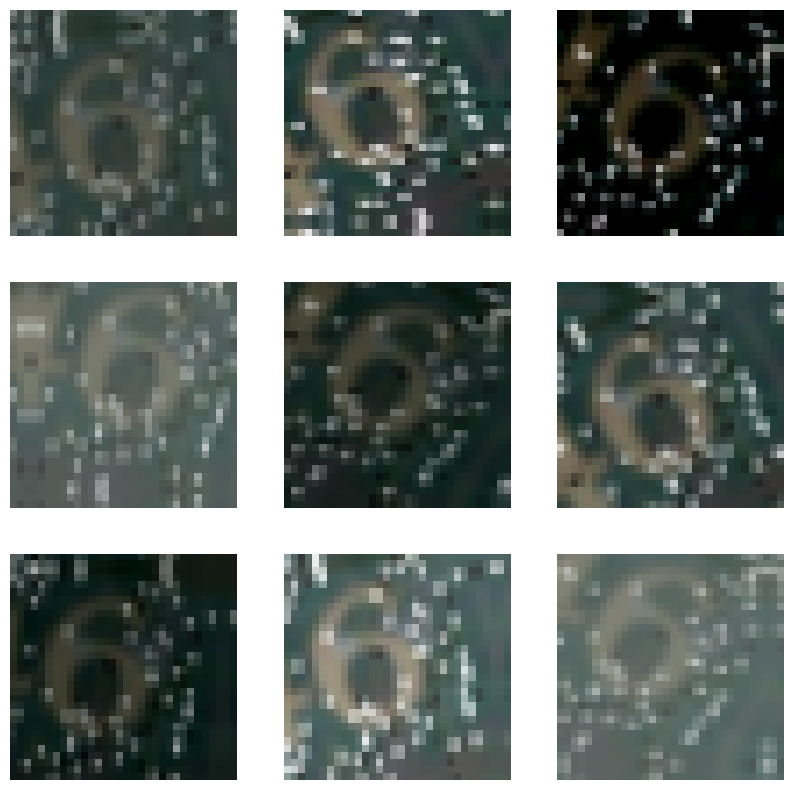

In [19]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


data_augmentation = tf.keras.Sequential([
  # layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomContrast(0.4),
  layers.RandomBrightness(0.2),
  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


plt.figure(figsize=(10, 10))
image = train_data['images'][11000]
image = tf.expand_dims(image, 0)
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((augmented_image[0]).astype('uint8'))
  plt.axis("off")

## Применение ко всем изображениям

In [8]:
orig_ds = tf.data.Dataset.from_tensor_slices((train_data['images'], train_data['labels']))
orig_val_ds, orig_train_ds = orig_ds.take(int(len(orig_ds) * 0.2)), orig_ds.skip(int(len(orig_ds) * 0.2))
print(len(orig_val_ds), len(orig_train_ds))

10000 40000


### Агментация только на самые малоразмерные классы

Вариация 1 (увеличение изображений в классе вдвое)

In [9]:
augment_train_ds = orig_train_ds
# ко всем цифрам 0, 8, 9 будут прибавлены по одной аугментированной
dict_augment_for_label = {
    0: 1,
    8: 1,
    9: 1
}
for label, value in dict_augment_for_label.items():
  for i in range(value):
    certain_label = orig_train_ds.filter(lambda x, y: y == label)
    aug_ds = certain_label.map(
    lambda x, y: (data_augmentation(x, training=True), y))
  augment_train_ds = augment_train_ds.concatenate(aug_ds)

Вариация 2 (увеличение изображений в классе на определенный процент)


In [20]:
augment_train_ds = orig_train_ds
dict_augment_for_label = {
    0: 1,
    8: 1,
    9: 1
}
# к 40% цифр 0, 8, 9 будут прибавлены аугментированные
percent_augment_label = 0.4
for label, value in dict_augment_for_label.items():
  for i in range(value):
    certain_label = orig_train_ds.filter(lambda x, y: y == label).shuffle(1000)
    certain_label = certain_label.take(int(len([i for i in certain_label]) * percent_augment_label))
    aug_ds = certain_label.map(
    lambda x, y: (data_augmentation(x, training=True), y))
  augment_train_ds = augment_train_ds.concatenate(aug_ds)



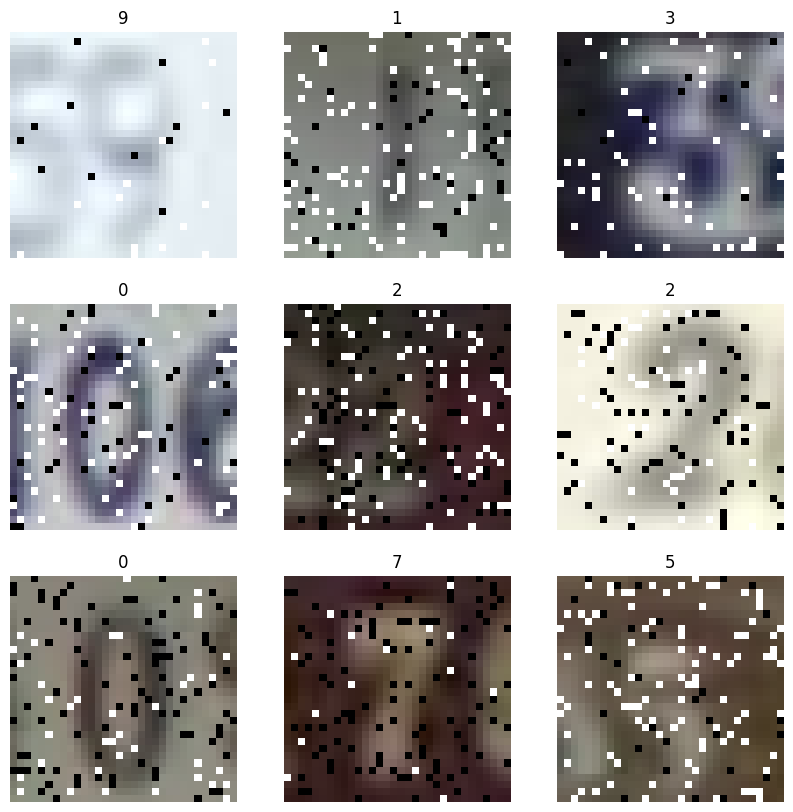

In [21]:
dataset = augment_train_ds.shuffle(buffer_size=1000)
dataset = dataset.take(9)
plt.figure(figsize=(10, 10))
for i, el in enumerate(dataset):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(el[0].astype('uint8'))
  plt.title(el[1].numpy())
  plt.axis('off')

In [22]:
len([i for i in augment_train_ds])

43152

# ResNet50

## Приведение train и val к нужному формату

In [23]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 32

resize_and_rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size).map(lambda x, y: (x, tf.one_hot(y, depth=10)))

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(augment_train_ds, shuffle=True)
val_ds = prepare(orig_val_ds)
# test_ds = prepare(test_ds)

## Обучение

In [24]:
from tensorflow.keras import layers

#СОЗДАЕМ МОДЕЛЬ 
input_shape = train_data['images'].shape[-3:]

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, Activation, Add,Dropout


# Определение функции для создания Residual блоков
def residual_block(inputs, num_filters, kernel_size, strides):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

# Создание модели ResNet-50 архитектуры
inputs = Input(shape=input_shape)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = residual_block(x, 64, 3, 1)
x = residual_block(x, 64, 3, 1)
x = residual_block(x, 64, 3, 1)
x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Activation('relu')(x)
x = residual_block(x, 128, 3, 1)
x = residual_block(x, 128, 3, 1)
x = residual_block(x, 128, 3, 1)
x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Activation('relu')(x)
x = residual_block(x, 256, 3, 1)
x = residual_block(x, 256, 3, 1)
x = residual_block(x, 256, 3, 1)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)


# Компиляция и обучение модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


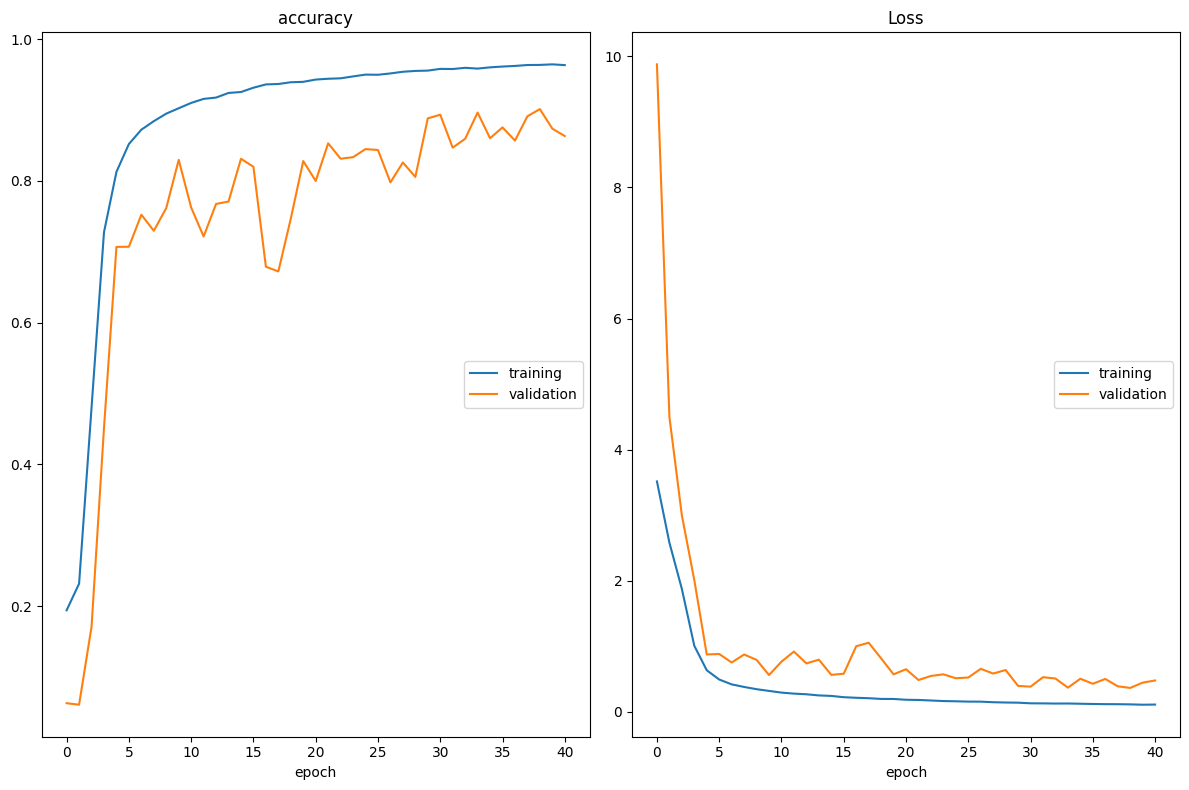

accuracy
	training         	 (min:    0.194, max:    0.964, cur:    0.963)
	validation       	 (min:    0.061, max:    0.901, cur:    0.863)
Loss
	training         	 (min:    0.107, max:    3.514, cur:    0.109)
	validation       	 (min:    0.363, max:    9.879, cur:    0.476)


KeyboardInterrupt: ignored

In [25]:
from livelossplot import PlotLossesKeras
import time 

start = time.time() 
model_history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[PlotLossesKeras()], verbose=False)
end = time.time() - start 
print("Время: "+ str(end) +' секунд')